In [5]:
# test reading in 10x data with AnnData
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob
import os
import pickle
from scipy import sparse
import anndata as ad
import scrublet as scr
from pathlib import Path
import scrublet as scr

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("Spectral"))
sns.set_style("whitegrid")

from matplotlib.ticker import StrMethodFormatter
# ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

import requests
from tqdm import tqdm

# data_dir = "C:/Users/randymi/Desktop/seuratwork/data"

data_dir = "/share/studies/Dermatology_Data/HS_Data_Portal/scanpy_seq/data/"

gsm_dict = {}

for root, folders, _ in os.walk(data_dir):
    for i in folders:
        if i.startswith("GSM"):
            gsm_dict[i.split("_")[0]] = str(Path(os.path.join(root,i)))

# linux has different delimiters:
def detect_delimiter(path):
    if '/' in path:
        return '/'
    elif '\\' in path:
        return '\\'
    else:
        return None  # No delimiter found

# returns full path from GSM number
def gsm_path(gsm):
    return gsm_dict["GSM" + str(gsm)]
df = pd.read_excel("../sample_list_healthy.xlsx")

hc_gsm = df.loc[df['HC Data'],["GSE","GSM"]]

hc_gs_zip = list(zip(list(hc_gsm.to_dict()['GSE'].values()), list(hc_gsm.to_dict()['GSM'].values())))
#adata = ad.read_csv(g_path + '\\' + g_path.split('\\')[-1]+'.csv').T

In [21]:
# GSE173706 uses csvs with no symbols????
shitter_gsm = [i[1] for i in hc_gs_zip if i[0] == "GSE173706"]
# get gene symbols for grch 38 gene symbols in GSE173706

# returns json object of gene symbols for a given list of ensembl ids:

# chunk it into 1000s
# add to final dict

symbol_dict = dict(symbols)

for gsm in tqdm(shitter_gsm, desc = "gsm"):
    file_path = os.path.join(gsm_path(gsm[3:]), os.path.basename(gsm_path(gsm[3:])) + '.csv')
    adata = ad.read_csv(file_path).T

    gene_ids = list(adata.var.index)

    gene_ids_idx = list(range(0, len(gene_ids), 900)) + [len(gene_ids)]

    for i in tqdm(range(len(gene_ids_idx) - 1), desc = "chunk"):
        chunk = gene_ids[gene_ids_idx[i] : gene_ids_idx[i+1]]

        chunk = [gene_id for gene_id in chunk if gene_id not in symbol_dict]

        if chunk:
            server = "https://rest.ensembl.org"
            ext = "/lookup/id"
            headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
            r = requests.post(server+ext, headers=headers, data='{ "ids" : [' + ', '.join(f'"{ensg}"' for ensg in chunk) + ' ] }')

            try:
                if r.status_code == 200:
                    response_data = r.json()

                    for key, value in response_data.items():
                        try:
                            val = value['display_name'] if 'display_name' in value else value['id']
                            symbol_dict[key] = val
                        except:
                            symbol_dict[key] = key

                else:
                    # try it again
                    r = requests.post(server+ext, headers=headers, data='{ "ids" : [' + ', '.join(f'"{ensg}"' for ensg in list(adata.var.index)) + ' ] }')

                    if r.status_code == 200:
                        response_data = r.json()
                        for key, value in response_data.items():
                            try:
                                val = value['display_name'] if 'display_name' in value else value['id']
                                symbol_dict[key] = val
                            except:
                                symbol_dict[key] = key
            except Exception as e:
                print(e)
                print(f"{gsm} FAILED\n")

    



symbol_dict = pd.DataFrame(symbol_dict.values(), index = symbol_dict.keys())
symbol_dict.columns = ["symbol"]
symbol_dict.to_csv("symbol.csv")

gsm: 100%|██████████| 8/8 [00:50<00:00,  6.27s/it]


In [2]:
# read in symbols for GSE173706

symbols = pd.read_csv("symbol.csv", index_col = 0)
symbols = symbols["symbol"]


# reads in a dir from GSM, returns adata
def read_dir(gse_code, gsm_code):

    data_path = gsm_path(gsm_code[3:])

    if gse_code == "GSE173706":
        adata = ad.read_csv(os.path.join(data_path, os.path.basename(data_path) + '.csv')).T
        adata.var["symbol"] = symbols[adata.var.index]
        adata.obs['cell_id'] = adata.obs.index.copy()

    else:
        matrix_path = os.path.join(data_path, 'matrix.mtx')
        barcodes_path = os.path.join(data_path, 'barcodes.tsv')
        features_path = os.path.join(data_path, 'features.tsv')
        
        adata = sc.read_mtx(matrix_path)
        adata_bc = pd.read_csv(barcodes_path, header=None, delimiter = "\t")
        adata_features = pd.read_csv(features_path, header=None, delimiter = '\t')
        
        adata = adata.T

        adata.obs['cell_id'] = adata_bc[0].values

        # gene ids
        adata.var['symbol'] = adata_features[1].values

        # make ensembl id the gene index since it is unique
        adata.var_names = adata_features[0].values

    # Each cell gets unique name
    adata.obs_names = [f"cell_{i:d}" for i in range(adata.n_obs)]
    
    adata.obs["GSM"] = gsm_code[3:]

    # GSE is batch key
    adata.obs["batch"] = gse_code[3:]
    
    return adata


def before_scrublet_step(adata):
    # preprocess healthy data

    print(f"Preqc cells: {adata.n_obs}")

    # mitochondrial genes
    adata.var["mt"] = adata.var["symbol"].str.startswith("MT-")

    # ribosomal genes
    adata.var["ribo"] = adata.var["symbol"].str.startswith(("RPS","RPL"))

    # hemoglobin genes
    adata.var["hb"] = adata.var["symbol"].str.contains("^HB[^(P)]")

    # calculate qc metrics
    sc.pp.calculate_qc_metrics(
    adata,
    qc_vars = ["mt","ribo","hb"],
    inplace = True,
    )

    # filter cells and genes
    sc.pp.filter_cells(adata, min_genes = 300)

    # remove cells with mitocondrial dna > 20%
    adata = adata[adata.obs["pct_counts_mt"] < 20]

    # remove cells with ribosomal dna > 55%
    adata = adata[adata.obs["pct_counts_ribo"] < 55]

    # remove genes expressed in less than 3 cells 
    sc.pp.filter_genes(adata, min_cells = 3)

    # remove genes with total counts under 3
    sc.pp.filter_genes(adata, min_counts = 3)

    return adata



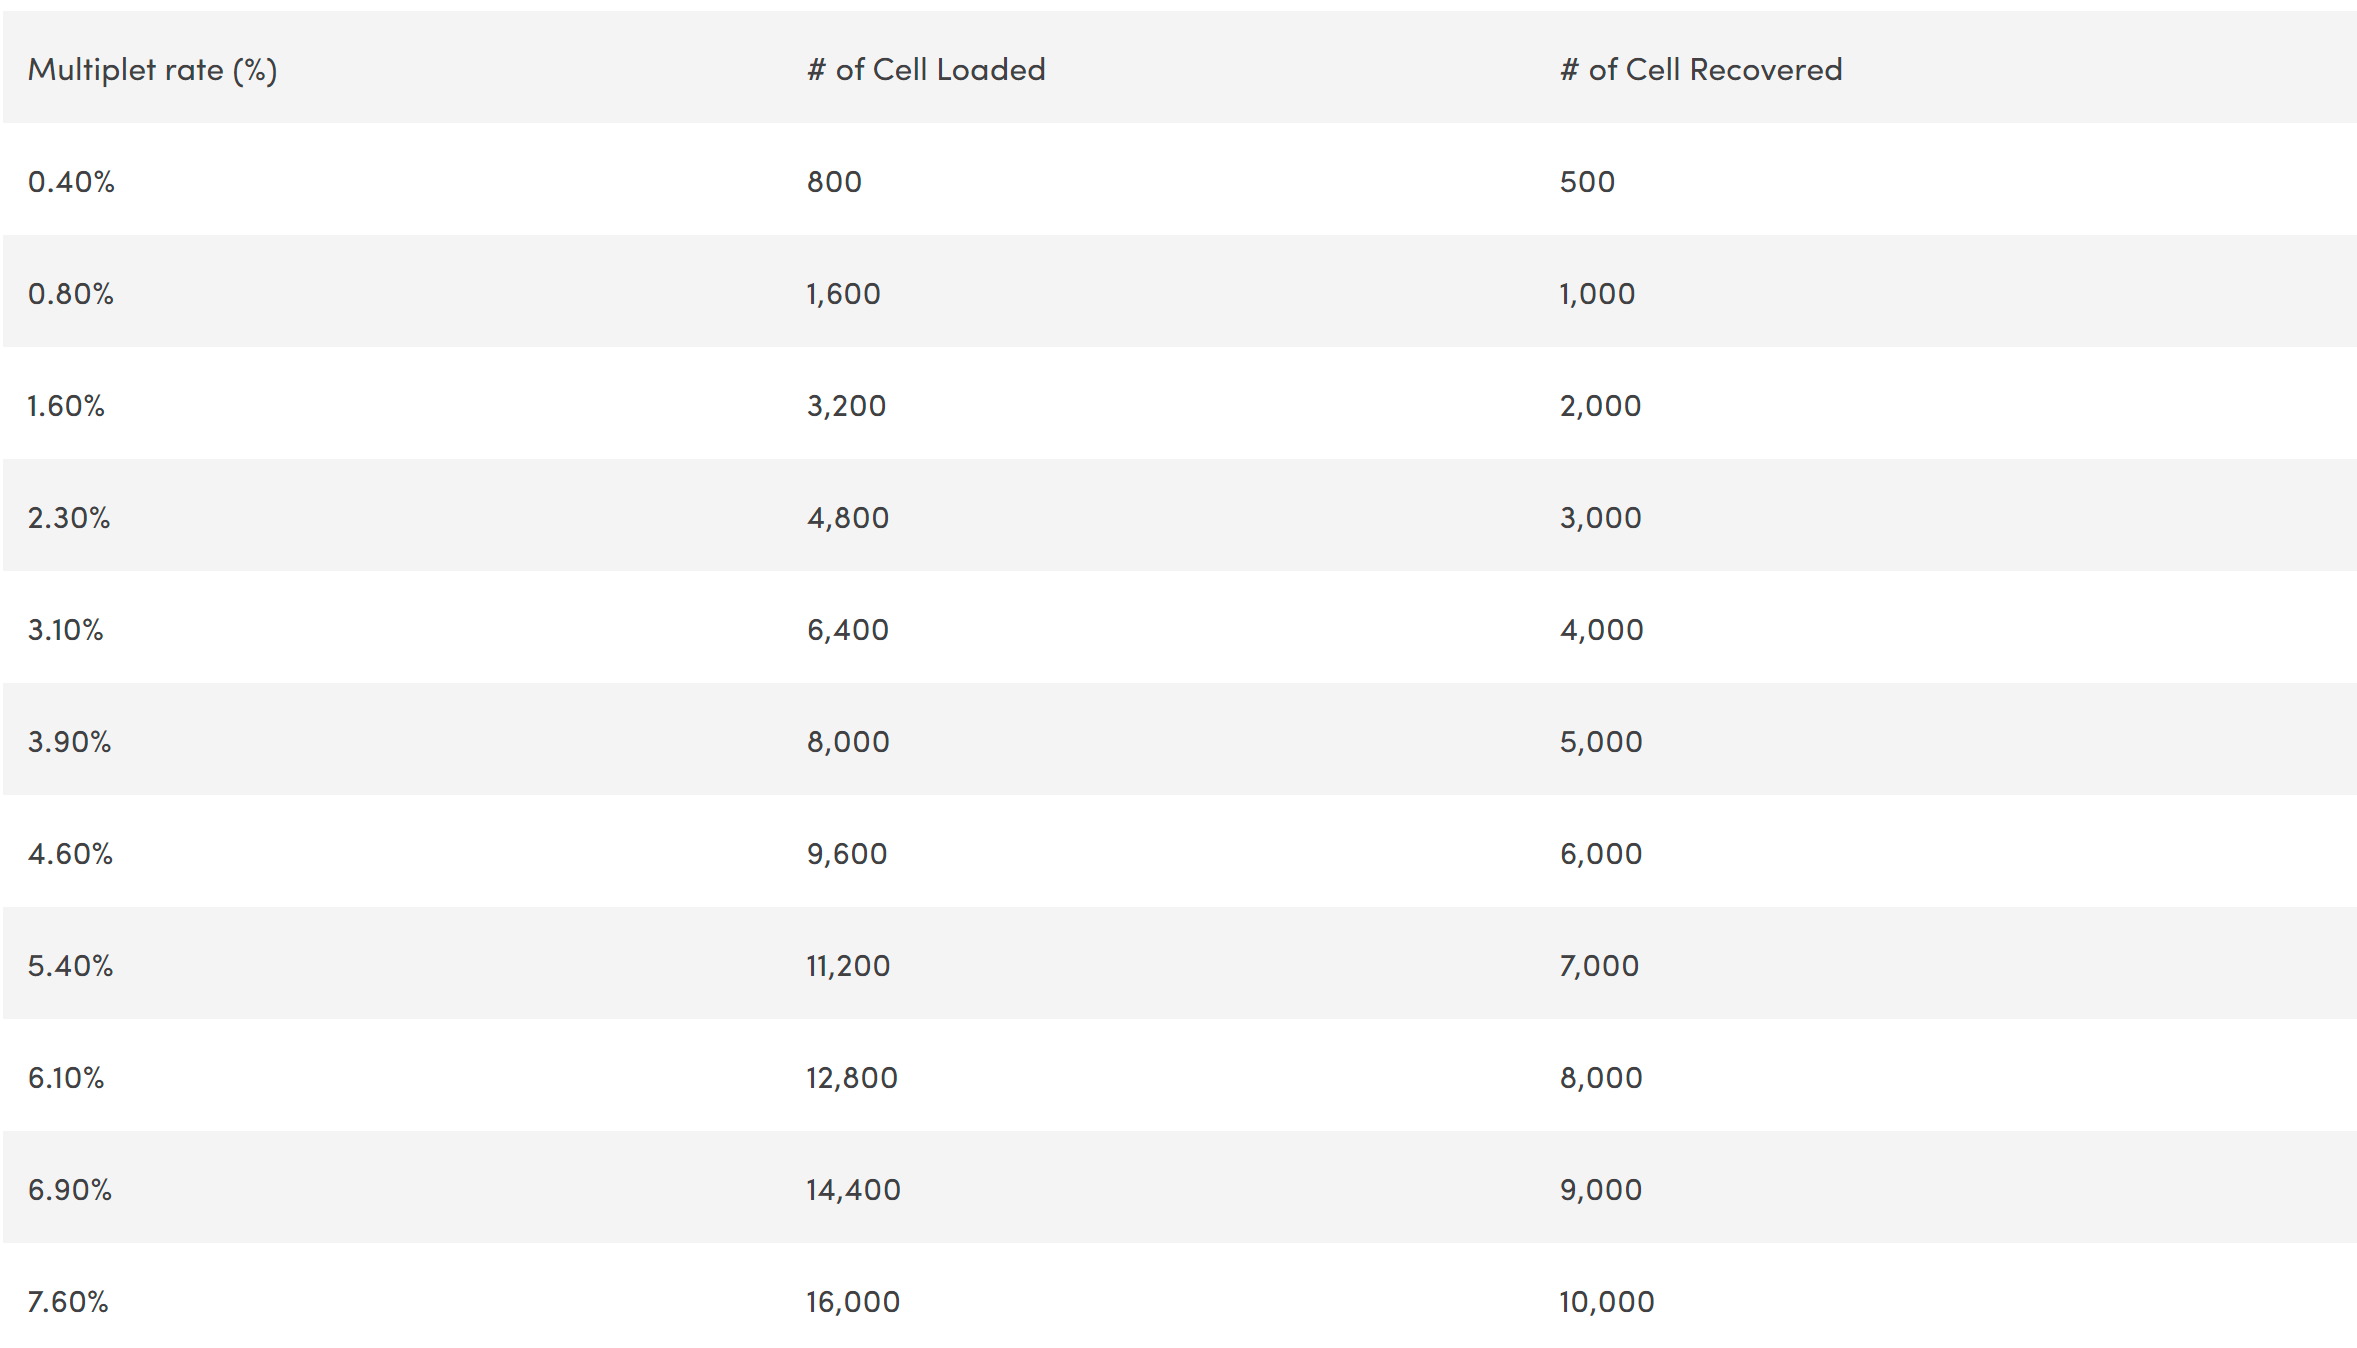

In [ ]:
from scipy.interpolate import interp1d

multiplet_rate = np.array([0.40, 0.80, 1.60, 2.30, 3.10, 3.90, 4.60, 5.40, 6.10, 6.90, 7.60])/100
cells_loaded = np.array([800, 1600, 3200, 4800, 6400, 8000, 9600, 11200, 12800, 14400, 16000])

multiplet_rate_interp = interp1d(cells_loaded, multiplet_rate, kind = 'linear')


for GSE, GSM in tqdm(hc_gs_zip):
    path = os.path.join("preprocessing",GSE,GSM)

    if not os.path.exists(path):
        os.makedirs(path)
        
    # does first part of qc
    adata = read_dir(*(GSE, GSM))

    adata.write_h5ad(os.path.join(path, f"{GSM}_raw.h5ad"))

    preqc_cells = adata.n_obs

    adata = before_scrublet_step(adata)

    scplot(sc.pl.violin, adata, ["pct_counts_mt","pct_counts_ribo","pct_counts_hb"], title = "GSM5277170_qc", path = path)

    # set expected doublet_rate accordingly
    doublet_rate = multiplet_rate_interp(adata.n_obs)


    scrub = scr.Scrublet(adata.X, expected_doublet_rate = doublet_rate)
    adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_gene_variability_pctl=85, n_prin_comps=30)
    scrub.plot_histogram()
    plt.savefig(os.path.join(path,f"{GSM} scrublet hist.png"))
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    scrub.plot_embedding('UMAP', order_points=True)
    plt.savefig(os.path.join(path,"GSM5277170 scrublet umap.png"))

    # scrublet threshold should be between two bimodel distributions in the pit
    # use this to fix if not
    # scrub.call_doublets(threshold=new_threshold)

    adata = adata[~adata.obs["predicted_doublets"]]

    # post scrublet steps
    sc.pp.filter_cells(adata, max_genes = 6000)

    # remove cells with rna counts > 40000
    adata = adata[adata.obs["total_counts"] < 40000]

    postqc_cells = adata.n_obs

    pd.Series({"doublet rate" : doublet_rate, "preqc cells" : preqc_cells, "postqc cells" : postqc_cells}).to_csv(os.path.join(path, "args.csv"), header = False)

    adata.write_h5ad(os.path.join(path, f"{GSM}_pp.h5ad"))

In [ ]:
# first terminal

GSE = "GSE249793"
GSM = "GSM7964428"

path = f"/share/studies/Dermatology_Data/HS_Data_Portal/scanpy_seq/healthy data/preprocessing/{GSE}/{GSM}/"
adata = sc.read_h5ad(f"/share/studies/Dermatology_Data/HS_Data_Portal/scanpy_seq/healthy data/preprocessing/{GSE}/{GSM}/{GSM}_raw.h5ad")

preqc_cells = adata.n_obs

adata.var["mt"] = adata.var["symbol"].str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var["symbol"].str.startswith(("RPS","RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var["symbol"].str.contains("^HB[^(P)]")

# calculate qc metrics
sc.pp.calculate_qc_metrics(
adata,
qc_vars = ["mt","ribo","hb"],
inplace = True,
)

# filter cells and genes
sc.pp.filter_cells(adata, min_genes = 300)

# remove cells with mitocondrial dna > 20%
adata = adata[adata.obs["pct_counts_mt"] < 20]

# remove cells with ribosomal dna > 55%
adata = adata[adata.obs["pct_counts_ribo"] < 55]

# remove genes expressed in less than 3 cells 
sc.pp.filter_genes(adata, min_cells = 3)

# remove genes with total counts under 3
sc.pp.filter_genes(adata, min_counts = 3)


from scipy.interpolate import interp1d

multiplet_rate = np.array([0.40, 0.40, 0.80, 1.60, 2.30, 3.10, 3.90, 4.60, 5.40, 6.10, 6.90, 7.60])/100
cells_loaded = np.array([400, 800, 1600, 3200, 4800, 6400, 8000, 9600, 11200, 12800, 14400, 16000])
multiplet_rate_interp = interp1d(cells_loaded, multiplet_rate, kind = 'linear')

doublet_rate = multiplet_rate_interp(adata.n_obs)

scrub = scr.Scrublet(adata.X, expected_doublet_rate = doublet_rate)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_gene_variability_pctl=85, n_prin_comps=30)



# play with threshold
adata.obs['predicted_doublets'] = scrub.call_doublets(threshold = 0.26)
#plt.close("all")
#scrub.plot_histogram()
#plt.show()




scrub.plot_histogram()
plt.savefig(os.path.join(path,f"{GSM} scrublet hist.png"))
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)
plt.savefig(os.path.join(path,f"{GSM} scrublet umap.png"))

# can reset threshold to different value

adata = adata[~adata.obs["predicted_doublets"]]

# post scrublet steps
sc.pp.filter_cells(adata, max_genes = 6000)

# remove cells with rna counts > 40000
adata = adata[adata.obs["total_counts"] < 40000]

print(f"{GSM} pre_qc cells: {preqc_cells}")
print(f"{GSM} post_qc cells: {adata.n_obs}")

adata.write_h5ad(os.path.join(path, f"{GSM}_pp.h5ad"))
print("DONE")

In [ ]:
# SECOND TERMINAL

GSE = "GSE249793"
GSM = "GSM7964429"

path = f"/share/studies/Dermatology_Data/HS_Data_Portal/scanpy_seq/healthy data/preprocessing/{GSE}/{GSM}/"
adata = sc.read_h5ad(f"/share/studies/Dermatology_Data/HS_Data_Portal/scanpy_seq/healthy data/preprocessing/{GSE}/{GSM}/{GSM}_raw.h5ad")

preqc_cells = adata.n_obs

adata.var["mt"] = adata.var["symbol"].str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var["symbol"].str.startswith(("RPS","RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var["symbol"].str.contains("^HB[^(P)]")

# calculate qc metrics
sc.pp.calculate_qc_metrics(
adata,
qc_vars = ["mt","ribo","hb"],
inplace = True,
)

# filter cells and genes
sc.pp.filter_cells(adata, min_genes = 300)

# remove cells with mitocondrial dna > 20%
adata = adata[adata.obs["pct_counts_mt"] < 20]

# remove cells with ribosomal dna > 55%
adata = adata[adata.obs["pct_counts_ribo"] < 55]

# remove genes expressed in less than 3 cells 
sc.pp.filter_genes(adata, min_cells = 3)

# remove genes with total counts under 3
sc.pp.filter_genes(adata, min_counts = 3)


from scipy.interpolate import interp1d

multiplet_rate = np.array([0.40, 0.40, 0.80, 1.60, 2.30, 3.10, 3.90, 4.60, 5.40, 6.10, 6.90, 7.60])/100
cells_loaded = np.array([400, 800, 1600, 3200, 4800, 6400, 8000, 9600, 11200, 12800, 14400, 16000])
multiplet_rate_interp = interp1d(cells_loaded, multiplet_rate, kind = 'linear')

doublet_rate = multiplet_rate_interp(adata.n_obs)

scrub = scr.Scrublet(adata.X, expected_doublet_rate = doublet_rate)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_gene_variability_pctl=85, n_prin_comps=30)



# play with threshold
adata.obs['predicted_doublets'] = scrub.call_doublets(threshold = 0.32)
plt.close('all')
scrub.plot_histogram()
plt.show()




scrub.plot_histogram()
plt.savefig(os.path.join(path,f"{GSM} scrublet hist.png"))
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)
plt.savefig(os.path.join(path,f"{GSM} scrublet umap.png"))

# can reset threshold to different value

adata = adata[~adata.obs["predicted_doublets"]]

# post scrublet steps
sc.pp.filter_cells(adata, max_genes = 6000)

# remove cells with rna counts > 40000
adata = adata[adata.obs["total_counts"] < 40000]
print(f"{GSM} pre_qc cells: {preqc_cells}")
print(f"{GSM} post_qc cells: {adata.n_obs}")

adata.write_h5ad(os.path.join(path, f"{GSM}_pp.h5ad"))
print("DONE")

In [4]:
GSE = 'GSE173706'

GSM = 'GSM5277171'

path = os.path.join("preprocessing",GSE,GSM)

if not os.path.exists(path):
    os.makedirs(path)
    
# does first part of qc
adata = read_dir(*(GSE, GSM))

adata.write_h5ad(os.path.join(path, f"{GSM}_raw.h5ad"))

adata = before_scrublet_step(adata)

scplot(sc.pl.violin, adata, ["pct_counts_mt","pct_counts_ribo","pct_counts_hb"], title = "GSM5277170_qc", path = path)

# set expected doublet_rate accordingly
scrub = scr.Scrublet(adata.X, expected_doublet_rate = 0.005)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_gene_variability_pctl=85, n_prin_comps=30)
scrub.plot_histogram()
plt.savefig(os.path.join(path,f"{GSM} scrublet hist.png"))
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)
plt.savefig(os.path.join(path,"GSM5277170 scrublet umap.png"))

adata = adata[~adata.obs["predicted_doublets"]]

# post scrublet steps
sc.pp.filter_cells(adata, max_genes = 6000)

# remove cells with rna counts > 40000
adata = adata[adata.obs["total_counts"] < 40000]

print(f"post_qc cells: {adata.n_obs}")

adata.write_h5ad(os.path.join(path, f"{GSM}_pp.h5ad"))





,Unnamed: 0,AAACGAACACCCTTGT-1,AAACGAAGTCTTTATC-1,AAAGAACCATTAGGAA-1,AAAGGATAGGTTCCAT-1,AAAGGATTCTTAGGAC-1,AAAGGGCTCTCAGTCC-1,AAAGGTACAAGTGACG-1,AAAGGTATCTCCCAAC-1,AAAGTCCCATGGGTCC-1,...,TTTCCTCCAATTCTTC-1,TTTCCTCGTATTCCGA-1,TTTCCTCGTTCTCCTG-1,TTTGACTCAGCGTTTA-1,TTTGACTTCATACGGT-1,TTTGATCGTAGACTGG-1,TTTGATCTCGAGTGGA-1,TTTGATCTCGGCTTGG-1,TTTGATCTCTGTGTGA-1,TTTGGTTGTTTCGTAG-1
0,ENSG00000243485,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000237613,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000186092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ENSG00000238009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000239945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,ENSG00000277856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33534,ENSG00000275063,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33535,ENSG00000271254,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
33536,ENSG00000277475,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def chunk_list(lst, n):
    return [lst[i:i + n] for i in range(0, len(lst), n)]

# takes list of gsm codes, loop merge pickles three at a time
def merge_anndata(codes):
    first_chunk = True
    chunk_size = 3
    for chunk in tqdm(chunk_list(codes, chunk_size)):
        adatas = []
        for code in chunk:
            with open('preprocessing/pickles/{}.pkl'.format(str(code)), 'rb') as File:
                adatas.append(pickle.load(File))
        if not first_chunk:
            adatas.append(combined_adata)
        
        combined_adata = ad.concat(
                adatas,
                axis=0,
                join='outer'
        )
        
        first_chunk = False
    return combined_adata